# A1: Unconstrained Optimization

---

*Purpose*: The simplest kind of optimization problem is one without constraints---an *unconstrained optimization* problem. We will begin our study of optimization with this simple setting.

*Learning Objectives*:
- build and explore models with Grama
- learn the first-order necessary condition (FONC) and curvature condition
- use `gr.ev_min()` to optimize unconstrained problems with multiple minima
- apply these concepts to the context of Nonlinear Least Squares (NLS) model-fitting

*Reading*:
- Grama documentation, [verbs](https://py-grama.readthedocs.io/en/latest/source/language.html#verbs)
- del Rosario and Iaccarino (2024), Ch. 3 (Modeling process)
- Kochenderfer and Wheeler (2019), Ch. 1 (Intro to optimization), Ch. (Algorithms---skim only)



### Assignment Checklist

1. [?] Make sure you have answered all questions. These are marked with a **qX.Y**
1. [?] Make sure you complete the Project Task at the end of the assignment. These will scaffold your project progress during the semester.
1. [?] Make sure your notebook passes all `assert()` statements. You will not get full credit for the assignment if a single `assert()` fails.
1. [?] Make sure your notebook runs: `Kernel > Restart kernel and run all cells...`
1. [?] Upload your notebook to Canvas.


### Grading Rubric

Every assignment is worth 10 points; it is not possible to receive less than 0 points. For each question (qX.Y) on a given assignment, the following grading rubric will be applied. For every NI that you receive, one point will be subtracted from your assignment total. For reference, to receive an A- in this class, you will need an average of 9 points across your 5 best assignments, meaning you need to have at most one mistake on your final submission for 5 assignments. To achieve this, you should take advantage of both the Draft and Final submission deadlines.

| Category     | Needs Improvement (NI)                     | Satisfactory (S)                       |
|--------------|--------------------------------------------|----------------------------------------|
| Effort       | qX.Y left unattempted                      | qX.Y attempted                         |
| Assertions   | Code does not pass an `assert()`           | All `assert()`s pass, or no assertions |
| Observations | Any point under *observe* left unattempted | All *observe*s attempted and correct,  |
|              | Provided an incorrect observation          | or no *observe*s for that q            |


## S1: Grama Model Implementation

---

[Grama](https://joss.theoj.org/papers/10.21105/joss.02462) is an [open-source](https://github.com/zdelrosario/py_grama) Python package designed to support model analysis with quantified uncertainties. We will use it throughout the course to implement and analyze models.


In [1]:
import grama as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


Using Grama consists of two steps:

1. **Implement** the model, which consists of functions, bounds, and densities to describe the uncertainty
1. **Analyze** the model, which can involve optimization, inference, curve-fitting, uncertainty propagation, sensitivity analysis, etc.

To do analysis, we first have to implement the model. The following code demonstrates how to implement a simple model with Grama.


In [4]:
# NOTE: No need to edit; the following demonstrates how to implement a Grama model

# Define the function
def fun_example(x, y, z):
    # Perform computation
    return (x + y) ** z
# These must match the order used above!
var_example = ["x", "y", "z"]
# Name the output(s) of the function
out_example = ["f"]

# Grama syntax is a little strange, but is designed to promote readability of code
# using *functional programming patterns* and pipes `>>`
md_example = (
    gr.Model("Example")
    >> gr.cp_function(
        fun=fun_example, # Specify the function
        var=var_example, # Name the input(s)
        out=out_example, # name the output(s)
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        y=(-1, +1),
        z=(0.5, 2.0),
    )
)

# Once built, we can print a helpful summary of a Grama model
md_example.printpretty()


model: Example

  inputs:
    var_det:
      x: [-1, 1]
      z: [0.5, 2.0]
      y: [-1, 1]

    var_rand:

    copula:
      None

  functions:
      f0: ['x', 'y', 'z'] -> ['f']



The important parts of the code above:

> `gr.Model()` creates a blank Grama model

This is the starting point for creating a model. We can add things like functions, bounds on inputs, or a description of uncertainty to a model by using `comp`osition verbs.

> `gr.comp_function(md, ...)` adds a function to a Grama model

A function maps inputs to outputs; Grama models can have multiple functions.

> `>>` is the *pipe operator* in Grama

The pipe operator `>>` takes the left-hand-side and inserts it as the first argument into the right-hand-side function. So `gr.comp_function(md, ...)` can be written as `md >> gr.cp_function(...)`. We shorten the prefix `comp` to `cp` to tell Grama to use the pipe-enabled version of the verb.

> `gr.comp_bounds(...)` adds bounds for inputs to a Grama model

These are useful for specifying optimization bounds and setting nominal variable conditions.

> By specifying both *functions* and the *input space*, Grama models make sophisticated analyses very simple.

You'll get some practice using these Grama tools below.


### q1\.1 Add a function

Implement the following expression as a function, and add it to the grama model below.

$$f(x, y, z) = z \cdot \exp(x + y).$$

*Hint*: Feel free to pattern-match using the example code given above. If you need more direction for this, you can [read the documentation](https://py-grama.readthedocs.io/en/latest/source/language.html#model-building) on model building.


In [7]:
###
# TASK: Implement the function above, add it to md_task below
###
import math

# TASK: Uncomment and fill-in the `task` quantities below
def fun_task(x, y, z):
    return z * math.exp(x+y)
    pass
var_task = ['x', 'y', 'z']
out_task = ['f']


# TASK: Add fun_task as a function to this model
md_task = (
    gr.Model("Task model") >> gr.cp_function(fun = fun_task, var = var_task, out = out_task)
## YOUR CODE HERE

)

# NOTE: No need to edit this; use this to check your work
md_task.printpretty()
df_task_res = gr.eval_df(
    md_task,
    df=gr.df_make(x=+1, y=-1, z=+2)
)
assert(df_task_res[["f"]].equals(gr.df_make(f=2.0)))
print("Success!")


model: Task model

  inputs:
    var_det:
      y: (unbounded)
      z: (unbounded)
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      f0: ['x', 'y', 'z'] -> ['f']

Success!


### q1\.2 Add bounds

Add bounds from $[-1, +1]$ for `x, y, z` to the model `md_task`. If you do this correctly, the following code will produce a plot.


Calling plot_sinew_outputs....


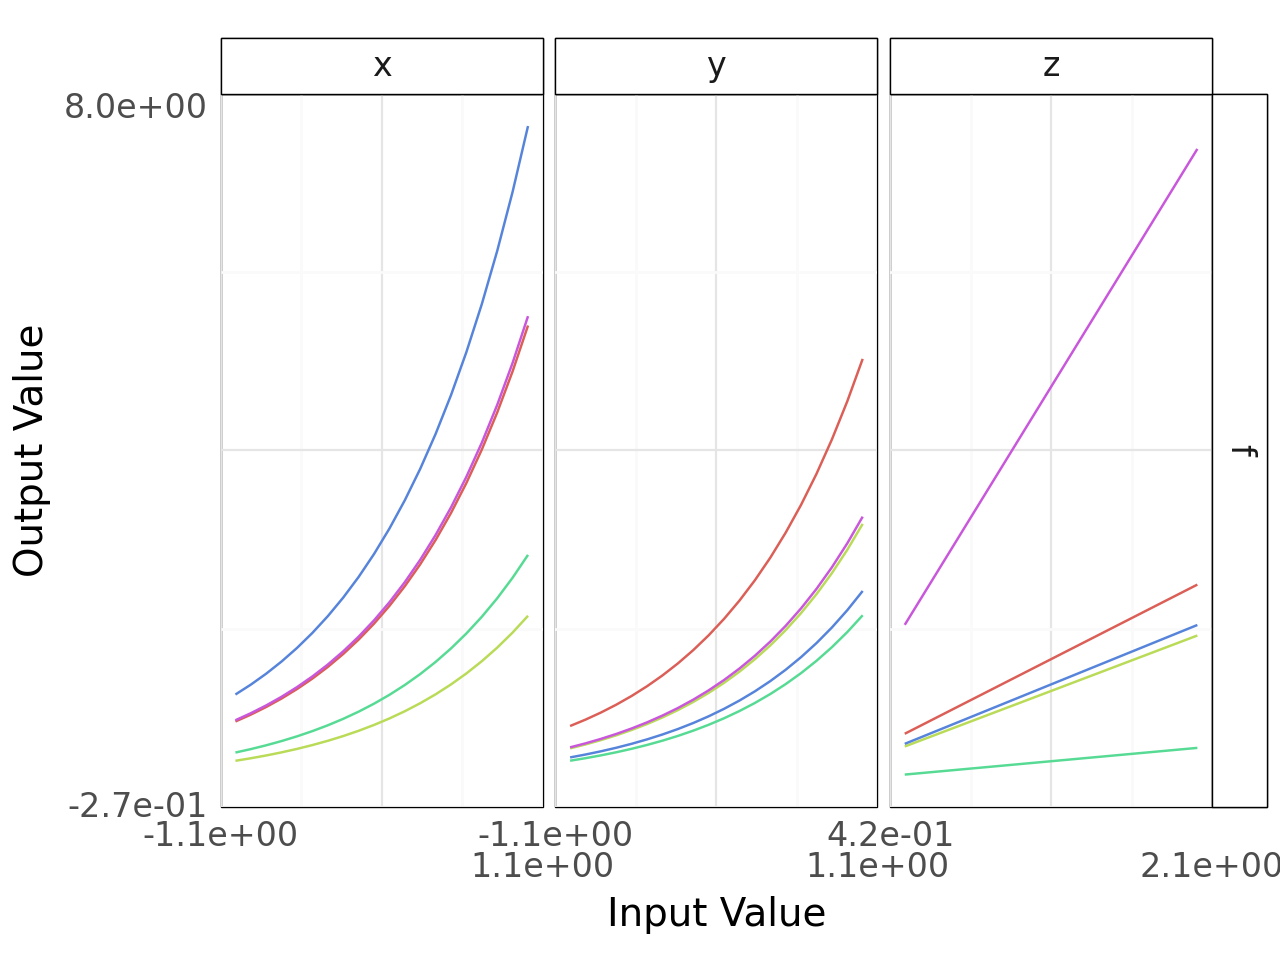

<Figure Size: (640 x 480)>

In [ ]:
###
# TASK: Add bounds to x, y, z in md_task
###

# TASK: Add bounds to this model - need to run q1.1 before 1.2 to instantiate 'md_task'
md_task = (
    md_task
# YOUR CODE HERE
    >> gr.cp_bounds(
            x=(-1, +1),
            y=(-1, +1),
            z=(0.5, 2.0),
        )

)

# NOTE: No need to edit; this will construct "ceteris paribus" plots
#       for your model
(
    md_task
    >> gr.ev_sinews(df_det="swp", n_sweeps=5, n_density=20, seed=101)
    >> gr.pt_auto()
)


Once you've build a Grama model, you can use Grama verbs to carry out very sophisticated analyses with few lines of code. For instance, the code above generates parameter sweep plots for your model, which economists and machine learning researchers use to understand the effects of variables on a model. In the Case Study below we'll see how we can use Grama to do curve fitting as well.


## S2: Tenchi Diagrams: The System Boundary

---

As engineers, we don't do optimization just for fun, we use optimization to help make decisions about *systems*. To do this, we need to first *define the system* we're interested in. One of the first and most important steps in defining a system is to draw the *system boundary*. This boundary defines what we're interested in studying (what's inside the system), and what lies outside the scope of our study (what's outside the system).

As an example, let's return to a system we studied all the way back in ModSim (Worksheet 3): Phillips' study of HIV infection dynamics. Figure 1 depicts the stock-and-flow model he used, and a system boundary defining what the model represents.

<img src="./images/tenchi-phillips1996.png" width="400">

**Figure 1.** Tenchi diagram of a model for HIV infection dynamics. Notice how only certain cell types (CD4 Lymphocytes) and virions are included in the system boundary (dashed line). Other cell types (red blood cells) are not included, and hence not tracked in the model.

Notice that Phillips' model represents a *tiny* fraction of the body: only 1 mm^3 of blood! Furthemore, the system boundary "squiggles" to avoid parts of the body Phillips doesn't want to study. The model includes CD4 Lymphocites (a type of white blood cell), but excludes red blood cells. Notice that CD4 Lymphocytes are represented by variables in the model (R, L, E), but red blod cells are not represented in the model.

Drawing the system boundary is an important source of *model assumptions*. We often have to make assumptions to represent *interactions* between the system and its environment; that is, whenever things *cross the system boundary*. That's what the $\Gamma\tau$ term in Phillips' model represents: additional CD4 Lymphocytes produced by the body which enter our small volume of blood.

Even when something is inside the system, we must make assumptions about how we will *represent* it. For example, Phillips' model tracks the number of free viral particles *only* in terms of count $V$. Real virions tend to decay over time, so each viral particle will have its own lifetime. However, Phillips decided to represent virion death using a steady rate ($\sigma$) that does not account for individual lifetimes.

Finally, when doing optimization, we make additional choices about howe we interact with the system. We will choose a set of *decision variables* that we seek to modify, and leave all other quantities as fixed *parameters*. The "with respect to" (wrt) line of an optimization problem specifies which quantities are decision variables; everything else in the model is treated as a fixed parameter *while we solve the optimization problem*. However, just because something is a parameter doesn't mean we don't have influence over it.

Next, let's return to the simple model for the Arecibo Observatory that we saw in NB0 (Fig. 2):

<img src="./images/tenchi-springoverhead.png" width="400">

**Figure 2.** Tenchi diagram of our simple model for the Arecibo Observatory, top view.

We also had a model for the location $\vec{x}\in\mathbb{R}^2$ of the suspended mass, given the anchor locations $\vec{v}_i\in\mathbb{R}^2$ and spring constants $k_i$.

$$\min E(\vec{x}) = \frac{1}{2}\left(K_1 \|\vec{x} - \vec{v}_1\|_2^2 + K_2 \|\vec{x} - \vec{v}_2\|_2^2 + K_3 \|\vec{x} - \vec{v}_3\|_2^2\right)$$
$$\text{wrt} \,\vec{x}$$

You'll study this system in the following task.

### q2\.1 Study the system boundary

Answer the following questions.

*Hint*: Remember that we were using optimization to *solve* a physics problem. So in this case, the "decision variables" are not so much things we're tweaking in design, but unknown quantities that we're trying to solve for. 

*Observe*:

- Is the suspended mass represented in the model? If yes, what quantity represents it, and how is it represented?
  - Yes, the mass is represented in the model. It is drawn on the diagram (labeled 'mass'), and is represented by the x vectors in the equation. The actual mass amount isn't represented, but rather the x/y location of the mass.
- Are the towers represented in the model? If yes, what quantities represent them, and how do they represent them?
  - Yes, the towers are represented in the model as the fixed anchors in the diagram and as the v vectors in the equation. 
- Are the main cables represented in the model? If yes, what quantities represent them, and how do they represent them?
  - Yes, the main cables are represented in the model as the resistors attaching the mass to the fixed anchors. They are represented as the 'K' (K1, K2, K3 being each individual wire) values in the equation. 
- Are the backstays (supporting cables) represented in the model? If yes, what quantities represent them, and how do they represent them?
  - This one is interesting, because while no, they are not represented in the model or the equation, in my opinion, they *do* appear in the assumption that the anchor is "fixed". Wrapped in that assumption is the presence of the cables - and your confidence in how well they will help maintain the fixed nature of the anchors is a pretty important consideration when deciding which use cases are valid and useful for this model.
- What are our decision variables?
  - vector v 
  - if changing Ki, then Ki, otherwise this is a parameter
- Given your answers to the previous questions, can we determine how tower placement affects suspended mass location?
  - Yes.
- Given your answers to the previous questions, can we determine how strong the towers need to be?
  - No. This model determines where the mass might sit. It is not fit (or written) to determine the required strength of the supporting towers.


### What's in the system? What's not?

Drawing the system boundary is a key first step to building a model. However, it's also important to maintain some awareness of what we're *not* modeling---what's outside the system we've defined. 

For instance: Nowhere in our tenchi diagram (Fig. 2) did we depict *wind*---neither in the natural world nor in the model. However, Arecibo is in Puerto Rico, which is subject to severe storms. Also, nowhere did we depict ongoing activities like maintenence. The Arecibo Observatory actually collapsed in late 2020, in [large part](https://doi.org/10.17226/26982) due to damage from storm winds and lack of proper maintenence.


## S3: Optimization: Necessary Conditions

---

In this section, we'll discuss the necessary conditions for *minimizing* a function. We'll also take a look at the workhorse optimization routine `scipy.optimize.minimize`.


### *Aside*: What about Maximization?

Maximizing an objective function can be trivially reformulated as minimization. If we seek to maximize a function

$$\text{max}\, y(x)$$
$$\text{wrt.}\, x$$

Then we can formulate it as

$$\text{min}\, -y(x)$$
$$\text{wrt.}\, x$$

For this reason `scipy` only implements a `minimize` routine; you'll need to negate your objective if you want to do maximization!


## Running Example

For this section we'll consider a running example:

$$f = \sin(3/2 \pi x) + x^2$$

The following code implements this function and visualizes it across an interval.


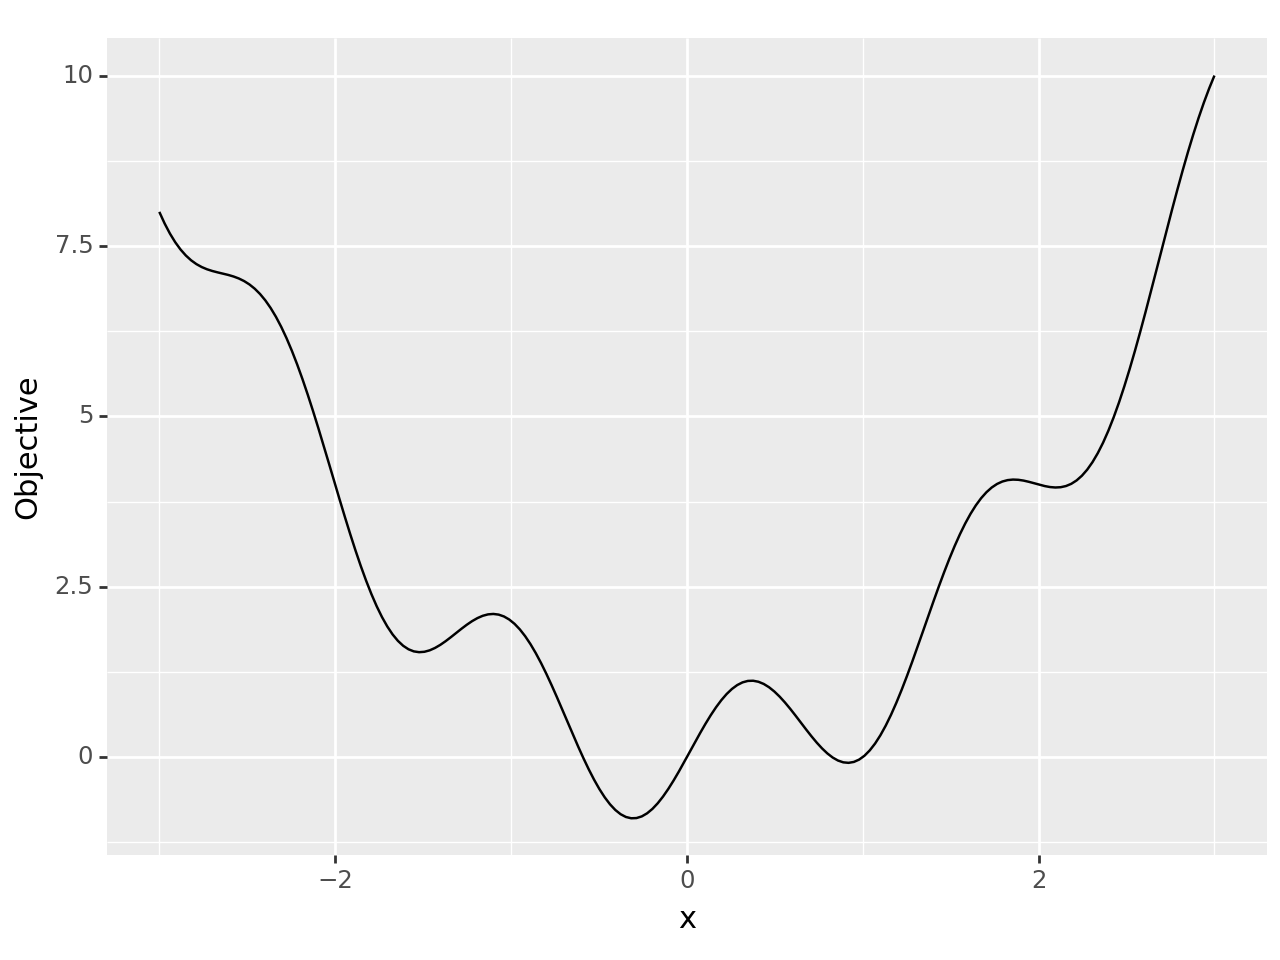

<Figure Size: (640 x 480)>

In [9]:
# NOTE: No need to edit, this code sets up the objective function
fun_multi = lambda x: np.sin(1.5 * np.pi * x) + x**2
md_multi = (
    gr.Model() 
    >> gr.cp_function(
        # NOTE: `lambda` is the "inline function definition" keyword;
        #       this is just a shortcut to help us define a function
        fun=fun_multi,
        var=["x"],
        out=["f"],
    )
)

# Compute data and visualize
(
    md_multi
    >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, n=200)))
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_line()
    + gr.labs(x="x", y="Objective")
)


## First-Order Necessary Condition (FONC)

The first-order necessary condition for optimality is that the gradient of the objective function equals zero, that is $\nabla f(x) = 0$.

As we'll see below, this alone is a *necessary*, but *not sufficient* condition for optimality.


### q3\.1 Compute the derivative to apply the FONC

Derive the gradient of the function above and answer the questions below.


[-0.25862394091183466, -0.25862394091183855, -0.25862394091183466, 0.48112506967022317, 0.7233771680049506, 0.48112506967022145, -0.25862394091183466]
[-0.8717781052785796, -0.8717781052785838, -0.8717781052785796, 0.9986042894442468, 0.25920223806621856, 0.9986042894442503, -0.8717781052785796]


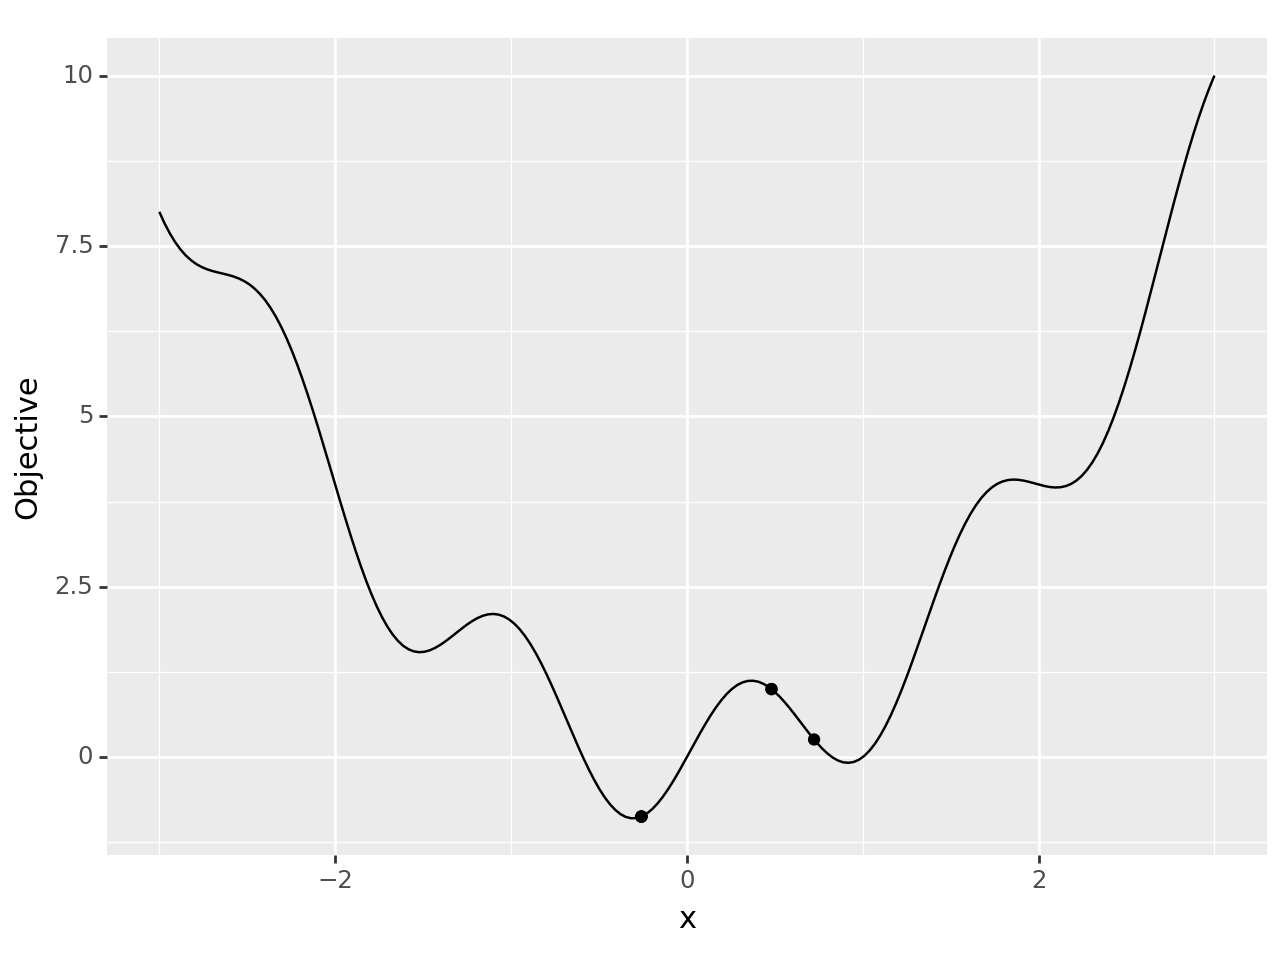

<Figure Size: (640 x 480)>

In [14]:
###
# TASK: Derive the gradient (derivative) of the function above,
#       implement it as a function.
###

fun_prime = lambda x: (3/2)*np.cos( (3/2)*np.pi*x ) + 2*x


# NOTE: No need to edit, this will visualize your result
# Apply FONC via root-finding routine (Newton's method)
X_roots = list(map(
    lambda x0: sp.optimize.newton(fun_prime, x0),
    [-1.5, -1, -0.5, 0.5, 1, 1.5, 2.1]
))
F_roots = list(map(fun_multi, X_roots))
print(X_roots)
print(F_roots)

(
    md_multi
    >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, n=200)))
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_point(data=gr.df_make(x=X_roots, f=F_roots))
    + gr.geom_line()
    + gr.labs(x="x", y="Objective")
)


*Observe*:

- Does every point satisfying the FONC correspond to a "low" point on the objective function? (yes or no) 
  - No
- Provide an example of a point `x` with $f'(x) = 0$ that is not a "low" point on the function.
  - To be so honest none of them look like true "low" points; the two that are more obviously not "low" points are:
    - X: 0.48112506967022317, F: 0.9986042894442468
    - X: 0.7233771680049506, F: 0.25920223806621856
- How does the curvature of the function relate to whether a point is a minimum or a maximum?
  - The curvature (second derivative) tells you that the point it a minimum if it is positive, and a maximum if it is negative.


## Positive Curvature

The other necessary condition for minimality is that the hessian of the objective function (its second-derivative matrix) is [positive-definite](https://en.wikipedia.org/wiki/Definite_symmetric_matrix). This condition is a higher-dimensional analogue to having positive curvature, and it is denoted mathematically by $\nabla^2 f \succ 0$ (note $\succ$ rather than $>$).

The Hessian is the matrix of mixed second-order partial derivatives, that is

$$[\nabla^2 f]_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j}.$$

In the case where $x$ is one-dimensional (where there is only one scalar value for curvature), the hessian reduces to the familiar second derivative. The higher-dimensional case of the SONC essentially demands that "all" of the curvatures (in "every dimension") must be positive.

In order for a point to be a "low point", it needs to satisfy both the FONC and have positive curvature. These together are *sufficient* conditions for a point to be what we call a *local minimum*.


### q3\.2 Compute the 2nd derivative to apply the positive curvature condition

Derive the second derivative of the function above, implement it, and answer the questions below.


[0.48112506967022317, 0.7233771680049506, 0.48112506967022145]
[0.9986042894442468, 0.25920223806621856, 0.9986042894442503]


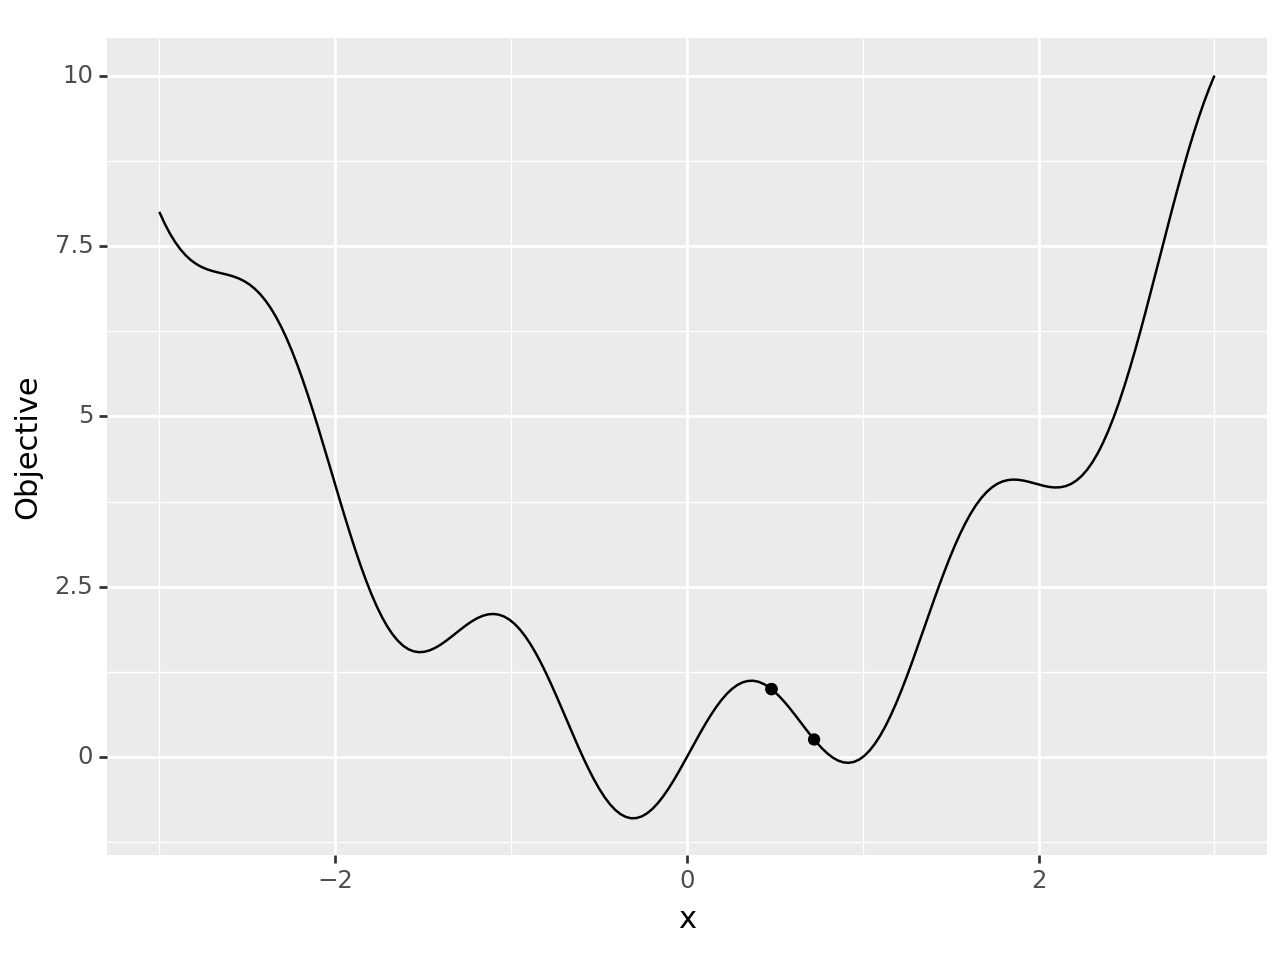

<Figure Size: (640 x 480)>

In [17]:
###
# TASK: Derive the second derivative of the function above,
#       implement it as a function.
###

fun_curvature = lambda x: (-9/4)*np.pi*np.cos( (3/2)*np.pi*x ) + 2


# NOTE: No need to edit, this will visualize your result
# Apply curvature check to filter points
X_min = list(filter(
    lambda x: fun_curvature(x) > 0, 
    X_roots
))
F_min = list(map(fun_multi, X_min))
print(X_min)
print(F_min)

(
    md_multi
    >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, n=200)))
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_point(data=gr.df_make(x=X_min, f=F_min))
    + gr.geom_line()
    + gr.labs(x="x", y="Objective")
)

*Observe*:

- Do each of the local minima (visualized as dots above) have the same Objective function value? (yes or no)
  - No, one has a value of 0.9986042894442468 and the other has a value of 0.25920223806621856.
- Is there one local minimum that seems to have the *smallest* Objective function value? If yes, roughly what $x$ value achieves that smallest value?
  - Yes, the point with 'x' value 0.7233771680049506 and 'f' value 0.25920223806621856.

- Are the FONC and positive curvature conditions together *sufficient* to guarantee the smallest objective function value (as opposed to a "locally-smallest" value)? (yes or no)
  - No? The smallest point is visibly off the local minimum, and it is *not* the global minimum of the section of graph shown in the plot.


### Some key terminology

Given a function $f(x)$:

- A *minimizer* of a function is a point $x^*$ that satisfies both the FONC $\nabla f(x^*) = 0$ and positive curvature $\nabla^2 f(x^*) \succ 0$.
- A *minimum* of a function is a function value $f^*=f(x^*)$ associated with a minimizer $x^*$.

Keep in mind that a *minimum* is a function value, while a *minimizer* is a point in the function's domain; they'll generally have different units and different dimensionality!

- A *global minimum* is the smallest value $f^*$ that $f(x)$ takes over its entire domain; functions that are *unbounded below* have a global minimum of $-\infty$. 
  - Similarly a *global minimizer* is a point $x^*$ that achieves the global minimum value. 
- A *local minimum* is any function value $f^*$ where the FONC and positive curvature conditions are met; a local minimum can also be the global minimum. 
  - Similarly a *local minimizer* is any point $x^*$ that achieves a local minimum value. There can be multiple, distinct *global minimizers*, but only one *global minimum*.

Full disclosure: These are *formal definitions* from optimization theory. While it's useful to know these definitions, we generally can't use them alone to solve practical optimization problems. Instead, we use an *optimization algorithm*.


## Iterative Optimization Algorithms

In this class we'll primarily talk about *using* optimization, not *developing optimization algorithms*. However, it's important to understand some basics about how most optimization algorithms work.

Most **iterative optimization** algorithms start with an initial guess $x_0$ and attempt to "improve" the function value $f(x_i)$ by searching for a new point $x_{i+1}$ where the value is lower $f(x_{i+1}) < f(x_i)$. The most intuitive approach is [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), where we "follow" the function gradient downhill ($-\nabla f$) until we stop moving. There is a veritable zoo of optimization algorithms that are much more efficient than gradient descent, but most tend to start with an initial guess and "run downhill".

The following code runs `scipy.optimize.minimize` on our running example `fun_multi`. The `minimize` routine takes a function to optimize $f$ and an initial guess $x_0$. It then "marches" towards a local minimum of the function. Note that `minimize` returns an output *object* (call it `res`), and that we can access its minimizer with `res.x` and minimum with `res.fun`.

Given what we've seen above, it should make sense that **the inital guess strongly affects where iterative optimization ends**.


### q3\.3 How does an optimization algorithm behave?

The following code picks a set of inital guesses $x_0$ and runs `minimize` for each one. Run the following code and answer the questions below.


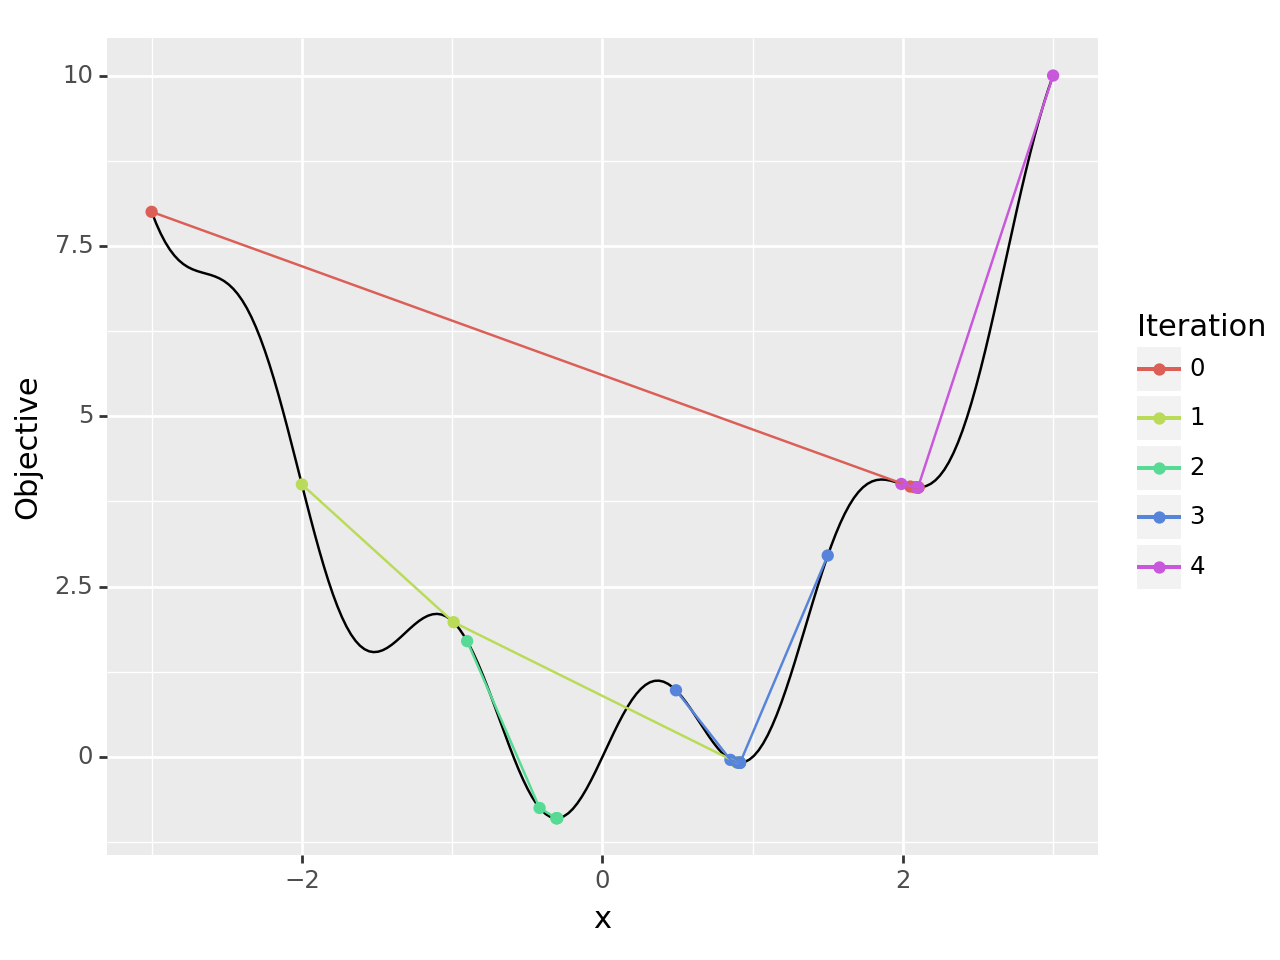

<Figure Size: (640 x 480)>

In [ ]:
# NOTE: No need to edit, run and inspect
# Run optimizer with several restarts
df_hist = pd.DataFrame()
x_starts = [-3, -2, -0.9, 1.5, 3]
for i, x in enumerate(x_starts):
    # Setup callback for storing history
    x_hist = [x]
    f_hist = [fun_multi(x)]
    def callback(Xi):
        global x_hist, f_hist
        x_hist.append(Xi[0])
        f_hist.append(fun_multi(Xi)[0])
        
    # Minimize
    res = sp.optimize.minimize(fun_multi, x, callback=callback)
    xs = res.x
    fs = res.fun
    
    # Store results
    df_tmp = gr.df_make(x=x_hist, f=f_hist, i=i)
    df_hist = pd.concat((df_hist, df_tmp), axis=0)

# Visualize
(
    md_multi
    >> gr.ev_df(df=gr.df_make(x=gr.linspace(-3, +3, n=200)))
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_line()
    + gr.geom_point(data=df_hist, mapping=gr.aes(color="factor(i)"))
+ gr.geom_line(data=df_hist, mapping=gr.aes(color="factor(i)"))
    + gr.scale_color_discrete(name="Iteration")
    + gr.labs(x="x", y="Objective")
)

Every distinct color represents the optimization *trajectory* (set of $x_i$) of a distinct initial guess.

*Observe*:

- Does every initial guess arrive at the same minimizer? (yes or no)
  - No
- Does every initial guess arrive at it nearest minimum? (yes or no)
  - No
- Do different initial guesses **sometimes** arrive at the same local minimum? (yes or no)
  - Yes
- In this case we are able to *visually identify* which minimum is the global minimum. Imagine we had a function with 100 input variables. Would we be able to use the same approach to *verify* a given local minimum is the global minimum? (yes or no) Why or why not?
  - I would say no.
  - No, simply because I'm not sure how to visually graph something with more than 3 dimensions, but I think you could compare the values from the local minimums to determine the global minimum.


These results suggest that we need to use iterative optimization algorithms with *caution*. The following heuristic is a good rule-of-thumb:

**Heuristic**: When seeking to minimize a function with an iterative algorithm, it is a good idea to test **multiple starting values** $x_0$ and check whether they arrive at the same minimizer $x^*$. The more trajectories that terminate at the same minimizer $x^*$ (with the smallest observed minimum value), the more credibility that point has as the possible global minimum of the objective function.

If all points arrive at the same minimizer $x^*$ then there is *no evidence* for local minima: Note that this does **not** prove that there are no local minima, only that we don't have evidence for other minima!

If distinct starting points arrive at different minimizers $x^*$ then we have clear evidence for the presence of local minima. Depending on your application you might be ok with this outcome. If multiple minima are unacceptable, it is sometimes possible to *reformulate* the problem to remove multiple minima; we'll see an example of this in the case study below.


### q3\.4 Optimizing a function

Use `gr.ev_min()` to search for the global minimum of the following function. Document your results from multiple restarts (at least ten).

*Hint*: Keep in mind that in Jupyter you can look up the documentation for a function by placing your cursor on the function and pressing `Shift + Tab`. This is useful for looking up the arguments of a function and understanding the structure of its output.

*Aside*: The function `gr.ev_min()` calls optimization routines from Scipy. You can look for the documentation for `scipy.optimize.minimize` for more details on the optimization routines available.


Estimated runtime: 0.0000 sec
Estimated runtime: 0.0000 sec
Results of all restarts:
          y         x       y_0       x_0             f  success  \
0  1.000062  1.000003  1.100000  1.100000  4.415461e-09     True   
1  1.000084  1.000000  0.648485  1.117867  6.980347e-09     True   
2  0.999686  1.000000  0.683561  0.832354  9.864655e-08     True   
3  0.999702  1.000046  1.002998  1.407920  2.767169e-07     True   
4  1.000006  0.670381  0.786967  0.737869  1.098737e-01     True   
5  0.999992  0.670383  1.513154  1.141962  1.098737e-01     True   
6  1.000094  1.329618  1.328993  1.203548  1.098738e-01     True   
7  1.000132  1.329614  1.285306  0.876239  1.098738e-01     True   
8  1.000001  1.600000  1.120665  1.594318  7.054915e-01     True   
9  0.676819  1.600000  1.334819  1.178790  8.970999e-01     True   

                                message  n_iter  
0  Optimization terminated successfully       5  
1  Optimization terminated successfully       7  
2  Optimization 

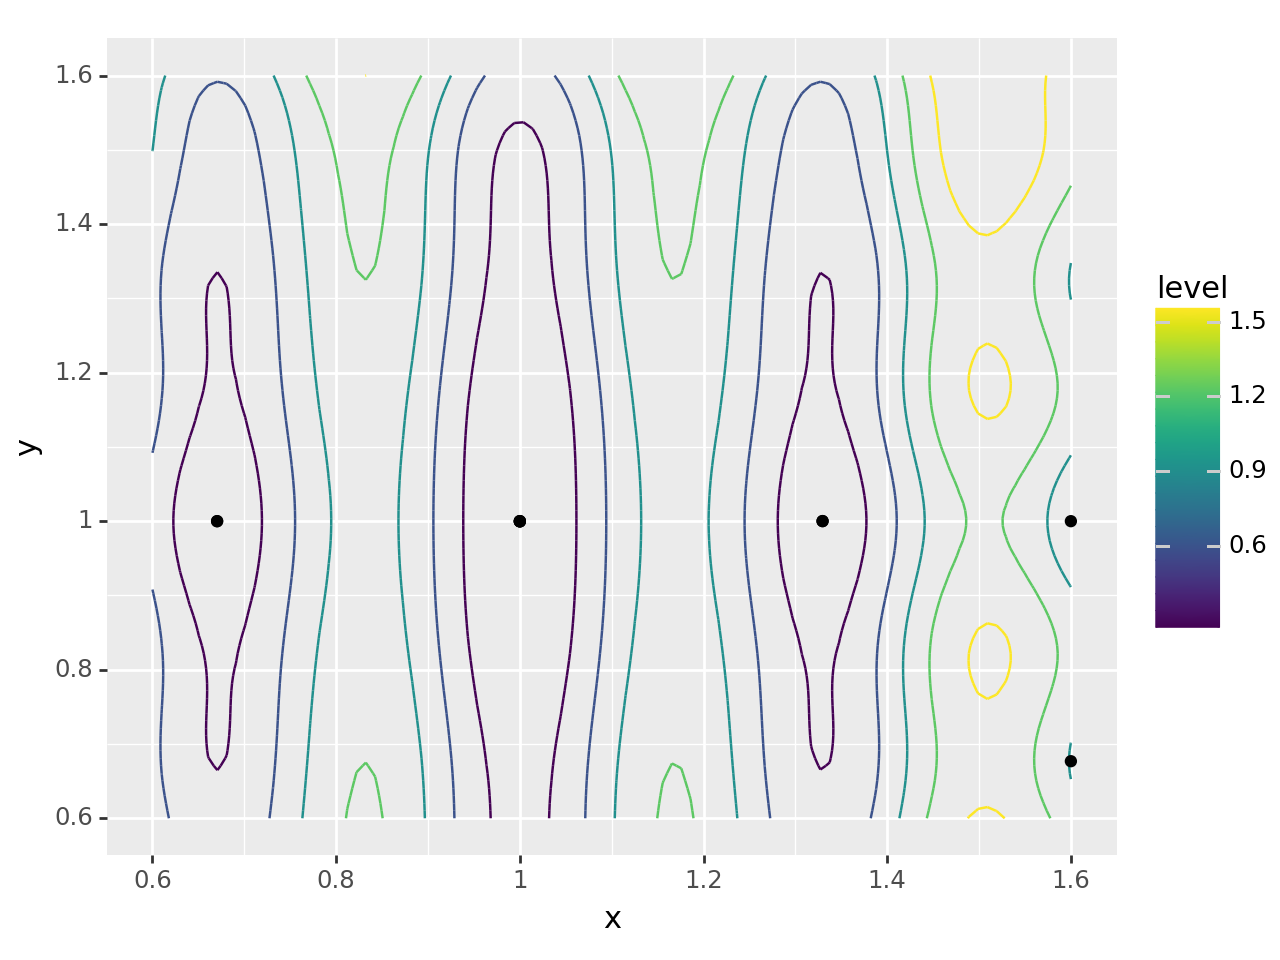

<Figure Size: (640 x 480)>

In [24]:
###
# TASK: Find the minimum of the provided function
###

# NOTE: No need to edit; find the minimum of this function (implemented as a grama model)
def fun_2d(x, y):
    """Levi's function"""
    return np.sin(3 * np.pi * x)**2 + \
        (x - 1)**2 * (1 + np.sin(3 * np.pi * y)**2) + \
        (y - 1)**2 * (1 + np.sin(2 * np.pi * y)**2)

md_2d = (
    gr.Model()
    >> gr.cp_function(
        fun=fun_2d,
        var=["x", "y"],
        out=["f"],
    )
    >> gr.cp_bounds(x=[0.6, 1.6], y=[0.6, 1.6])
)

# TASK: Use gr.ev_min() to search for the minimum of the function
df_2d = (
    md_2d 
    >> gr.ev_min(
    out_min="f",
    n_restart = 10
    )
)


# NOTE: Do not edit, your code should pass these checks
assert df_2d.shape[0] >= 10, "You must use at least ten restarts"
# NOTE: No need to edit; this visualizes your result
df_2d = df_2d >> gr.tf_arrange(DF.f)
print("Results of all restarts:")
print(df_2d)
print("Best result:")
print("  optimizer: {}, {}".format(df_2d.x[0], df_2d.y[0]))
print("  above global minimum: {}".format(df_2d.f[0]))
(
    md_2d
    >> gr.ev_contour(
        var=["x", "y"],
        out=["f"],
        n_side=100,
    )
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_segment(gr.aes(xend="x_end", yend="y_end", group="level", color="level"))
    + gr.geom_point(data=df_2d)
)

*Observe*:

- How far is your identified minimum above the global minimum? Is it greater than zero? (See the text printout above.)
  - The identified optimal minimum was 4.415461439815826e-09 above the global minimum. It is greater than 0, but it is very small. 
- Aside from the "above the minimum" value reported (which you would *not* have in practice), what evidence do you have that your minimum is the global minimum?  Does this *prove* that your minimum is the global minimum?
  - I know that the minimum given here is the global minimum shown in th plot because the point is visibly at a minimum level. 
  - I don't actually think this is very strong evidence, because there are other local minimums shown, but I think this isn't necessarily the global minimum across the entire function. I also don't even know if 1, 1 is a global minimum on this plot because the other minimums look like they're also getting to the lowest level, just for less space around? So 1,1 might just be very flat?


Multiple minima is not some abstract issue; it shows up in **real** engineering problems, as we'll see below.

## S4: Case Study: Least Squares Regression

---

Often we have some model for a physical system with *unknown parameters*. We can combine data with [least squares regression](https://en.wikipedia.org/wiki/Non-linear_least_squares) to *fit* the model---that is, optimize the agreement of the model with data to find optimal parameter values. This is a very common use of optimization, but the issue of multiple minima can make model fitting very difficult.

To illustrate, let's take a look at a case study involving the frequency response of a circuit. An LC circuit starting with initial voltage difference $V_0$ has the following current waveform:

$$i_{\text{true}}(t, \theta) = \sqrt{C/L} V_0 \sin(\sqrt{1/(LC)} \cdot t)$$

where $\theta = [V_0, C, L]$ is the vector of *parameters* for the model. We further assume that the true current value is corrupted by additive noise:

$$i_{\text{meas}}(t, \theta) = i_{\text{true}}(t) + \epsilon_{\text{noise}}$$

The following code plots this wave.


In [ ]:
# NOTE: No need to edit; this creates and visualizes our data
np.random.seed(101)
n = 100
df_data = (
    gr.df_make(t=np.linspace(0, 5, num=n))
    >> gr.tf_mutate(i_true=20 * gr.sin(2 * DF.t))
    >> gr.tf_mutate(
        i=DF.i_true + np.random.normal(size=n, scale=0.5)
    )
)

# Visualize
(
    df_data
    >> gr.ggplot(gr.aes("t", "i"))
    + gr.geom_point()
    + gr.labs(x="Time (s)", y="Current (Amps)")
)


### Application of NLS to Circuit Analysis

The expression $i_{\text{true}}(t, \theta)$ above is a parameterized function that we can fit with [Non-linear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) (NLS). NLS formulates an objective function for this fitting based on the *mean squared error* (MSE)

$$\text{MSE}(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^n (i_{\text{true}}(t_i, \hat{\theta}) - i_{\text{measured}}(t_i, \theta_{\text{true}}) )^2$$

Our assumption in NLS is that there exist some "true" parameter values $\theta_{\text{true}}$, and we seek to optimize $\hat{\theta}$ so as to minimize the MSE and recover the true parameters $\theta_{\text{true}}$. **Importantly** unless there is special structure in our parameterized function, there is no guarantee that there exists a single "best" parameter value $\hat{\theta}^*$ that minimizes the MSE. This can lead to multiple minima, as we'll see below.

Given all this, we can formulate NLS as an optimization problem:

$$\min\, \text{MSE}(\hat{\theta})$$
$$\text{wrt.}\, \hat{\theta}$$

In this case study we'll apply NLS to the circuit waveform. We'll break this down into steps:


### q4\.1 Implement the signal function

Implement the function

$$i_{\text{true}}(t, \theta) = \sqrt{C/L} V_0 \sin(\sqrt{1/(LC)} \cdot t)$$

as a Python function.


In [ ]:
###
# TASK: Implement the signal as a function
###

# NOTE: No need to edit this variable list
var_signal = ["t", "C", "L", "V0"]

def fun_signal(t, C, L, V0):
    # TODO: Implement the signal function
    return 0



# NOTE: No need to edit; use this to check your work
F = gr.Function(
    fun_signal,
    var_signal,
    ["i"],
    "Signal",
    0,
)
df_res = F.eval(gr.df_make(t=np.pi, C=0.25, L=1, V0=1))
assert(abs(df_res.i[0]) < 1e-15)

print("Success!")


Grama contains a routine `fit_nls()` that performs NLS automatically: It takes a dataset and a parameterized model, formulates the MSE objective, and runs `minimize` to find an optimal parameter value. To use `fit_nls()`, you must create a Grama model.

### q4\.2 Implement the signal as a Grama model

Add your function to the following Grama model.


In [ ]:
###
# TASK: Add the function you implemented above to the following model
###

# NOTE: No need to edit
md_signal = (
    gr.Model("Signal")
## TODO: Add your function from q3.1 here
#    >> ???

## NOTE: No need to change these bounds
    >> gr.cp_bounds(
        V0=(-10, 40),
        C=(0.1, 1),
        L=(0.5, 1.5),
    )
)

## NOTE: No need to edit; this will run NLS on your Grama model
md_fit1 = gr.fit_nls(
    df_data,
    md=md_signal,
    uq_method="linpool",
    seed=101,
)


*Observe*:

- What does the `success` column of the output indicate? What does this tell you about the optimization of the squared-error? Does this guarantee the `mse` reached the *global* minimum?
  - (Your response here)
- The output reports both the initial guess parameters (e.g. `V0_0`) and their optimized values (e.g. `V0`). Inspect these values and compare them against the original data. Are these values reasonable?
  - (Your response here)
- Compare the initial guess parameter values to the bounds set in `cp_bounds()` above; how are they related?
  - (Your response here)
- Try commenting out the bounds in the model definition above. What happens?
  - *Note*: Comment syntax in Python uses a hash symbol `#`
  - (Your response here)
- Do you get a `Warning` from `fit_nls()`? What does this warning say?
  - (Your response here)


The `fit_nls()` routine returns a new Grama model with the parameters "frozen" to the optimal value. Thus you can evaluate this new model to make predictions.

It is good practice when performing NLS to not only check the MSE, but to also visually inspect the fit.

### q4\.3 Visually inspect the fit

Use the Grama verb `eval_nominal()` to evaluate the fitted model `md_fit1` at the time points in the dataset `df_data`. Answer the questions below.


In [ ]:
###
# TASK: Evaluate the fitted model at its nominal conditions
###

## TASK: Use gr.eval_nominal() to evaluate md_fit1
##       at the given time points df_data
# df_res1 = ???


# NOTE: No need to edit, this will visualize your results
(
    df_data
    >> gr.ggplot(gr.aes("t", "i"))
    + gr.geom_line(data=df_res1)
    + gr.geom_point()
    + gr.labs(x="Time (s)", y="Current (Amps)")
)


*Observe*:

- **Qualitatively**, how does your `Fitted` signal compare with the `Measured` signal: well or poorly?
- What **specific features of the `Fitted` signal** do not match?
- Did the fitting with `fit_nls()` above have `success == True`? In what sense is a result with `success == True` optimal? What does this tell you about the relationship between a "successful" optimization of the squared-error and the quality of a fit?


As we saw in Section 2 above, *multiple starting points* can help us overcome issues of local minima. The `fit_nls()` routine has a keyword argument to automatically use a user-specified number of restarts, drawn randomly from the model bounds.

### q4\.4 Use multiple restarts

Consult the documentation for `fit_nls()` (remember `Shift + Tab`) and re-run `fit_nls()` with multiple restarts. Answer the questions below, then move on to the next code chunk to visually inspect your fit.

*Hint*: Using an appropriate number of restarts, it is possible to get a *very accurate* fit!


In [ ]:
### 
# TASK: Re-fit the model with fit_nls() using multiple restarts
# HINT: Read the documentation for fit_nls() to find a keyword argument
#       to control the number of restarts.
###

## TASK: Re-fit the model using at least 5 restarts
# md_fit2 = ???



*Observe*:

- How does the `fit_nls()` report differ from the results in q3?
  - (Your response here)
- How do the optimized MSE values compare across the multiple restarts? Which set of optimized parameters do you think `fit_nls()` returns?
  - (Your response here)
- Do you see multiple distinct restarts arrive at the same minimizing parameter value? What does this indicate about the fit?
  - (Your response here)
- Do you still get a `Warning` from `fit_nls()`? (yes or no)
  - (Your response here)


In [ ]:
###
# TASK: Visually inspect the results of your new fit
###

## TASK: Evaluate your model at its nominal conditions, 
##       visualize the fit against the measured data




### Unidentifiability and Local Minima

The `fit_nls()` routine keeps warning us that the model is "locally unidentifiable"; what does this mean? To explain, let's evaluate the circuit model at two *completely different* parameter vectors:


In [ ]:
# NOTE: No need to edit; run and inspect
df_test1 = gr.eval_df(
    md_signal,
    df=gr.tran_outer(df_data, gr.df_make(V0=20, L=0.5, C=0.5))
)
# NOTE: The following evaluates the signal model 
#       at **distinct** parameter values
df_test2 = gr.eval_df(
    md_signal,
    df=gr.tran_outer(df_data, gr.df_make(V0=40, L=1.0, C=0.25))
)

# Visualize both evaluations of the Signal model
# plt.figure()
# plt.plot(df_test1.t, df_test1.i, 'b-', label="Set 1")
# plt.plot(df_test2.t, df_test2.i, 'r--', label="Set 2")

# plt.xlabel("Time (s)")
# plt.ylabel("Current (Amps)")
# plt.legend(loc=0)

(
    gr.ggplot(gr.aes("t", "i"))
    + gr.geom_line(data=df_test1, color="red", size=2)
    + gr.geom_line(data=df_test2, color="blue", size=1, linetype="dashed")
    + gr.labs(x="Time (s)", y="Current (Amps)")
)

These two models lie **exactly** on top of each other, despite having different parameter values! This is what it means for a model to be [unidentifiable](https://en.wikipedia.org/wiki/Identifiability)---we cannot distinguish between different parameter values.

There are various ways to solve issues of identifiability; one way is to use some independent source of information to *fix* one of the parameters and leave it out of the fitting procedure.


### q4\.5 Fix a parameter

Recall that $V_0$ is the initial voltage difference across the circuit. Suppose we know that `V0 == 20` Volts for the experiment that generated our data. Override the bounds of the model to constrain the value of `V0` to `20`, re-fit the new model, and answer the questions below.


In [ ]:
###
# TASK: Override the bounds of the waveform model to fix V0
###

## TASK: Freeze the V0 parameter by setting new bounds
# md_freeze = ???
## TASK: Fit the new "frozen" model
# md_fit3 = gr.fit_nls(...)



*Observe*:

- With this "frozen" model, do you see multiple distinct restarts arrive at the same minimizer? What does this indicate about the optimization of the squared-error? Does this *guarantee* that your minimizer is the global minimizer?
  - (Your response here)
  - (Assess your evidence here)


## S5: Project Tasks

---

Look back on your project idea from the previous assignment. As we saw in this assignment, local minima can stymie optimization success. This project task will help you connect these ideas to your project.

### q5\.1 Model

*Task*: Draw your first tenchi diagram. This must include:
- A visual depiction of the natural world. Note: This cannot just be words in circles, you must use images (clipart or stick figures are fine).
  - Include a system boundary
  - Ensure that there are things inside and outside the system boundary
- A depiction of the model

(Your tenchi diagram here)

### q5\.2 Math

*Task*: Provide an answer to each point below:

- *Optimization objective*: What objective(s) are you seeking to optimize? How well can you formulate those mathematically? *Hint*: Your tenchi diagram should help you do this: The thing you're optimizing should be clearly depicted inside the system boundary.
  - (Your answer here)
- *Optimization variables*: What variables will you optimize your objective with respect to? (the `wrt` line in your optimization.) *Hint*: Your tenchi diagram should help you do this: The variables you're considering should be clearly represented by something inside the system boundary.
  - (Your answer here)
  
- *Sources of local minima*: Are there potential sources of local minima in your project?
  - (Your answer here)
  - *Note*: You can often use discipline-specific knowledge to help identify potential sources of local minima. As we saw above `L, C` combine to define the natural frequency of a circuit $\omega_0$. If your problem depends on *products* or *ratios* of physical quantities, then this is a likely mechanism for local minima in your problem.
- *Potential reformulation of your problem*: If you identified sources of local minima above, can you reformulate your problem to avoid these issues?
  - (Your answer here)
  - *Note*: One way to reformulate a model is to re-express the model in terms of a smaller parameter set. For example if two geometries enter into a problem `L, W` only as an aspect ratio `AR = L/W`, then you can replace both `L, W` with `AR` alone. 
  - *Note*: If you can *fix* one of the variables in your optimization (as we did with the NLS case study above), this is another way to "solve" issues of local minima.
- *Computational tractability of multiple restarts*: Will it be *computationally tractable* to run multiple restarts of your model? 
  - (Your answer here)
  - *Note*: If you are using an expensive simulation (e.g. FEA) multiple restarts may not be feasible.

### q5\.3 People

*Task*: Analyze your problem through a lens of (technomoral) humility: List at least *two things* your model can't account for, and what issues (for you, for users, for society...) those might pose.

*Hint*: Your tenchi diagram should help you do this. In particular, things that are *outside* the system boundary are things that you *cannot account for* in your optimization. Clearly, these can raise issues.

- (Your first thing)
  - (What issue(s) that might raise)
- (Your second thing)
  - (What issue(s) that might raise)